<h1>Importando bibliotecas</h1>

In [31]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw
from numpy import asarray
from scipy.spatial.distance import cosine
from mtcnn.mtcnn import MTCNN
from collections import defaultdict
from glob import glob
from random import choice, sample, shuffle
from keras.preprocessing import image
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras_vggface.utils import decode_predictions
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Input, Dense, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract, Reshape, Flatten
from keras.models import Model
from keras.optimizers import Adam, Adagrad, RMSprop
from keras import regularizers
from IPython.display import clear_output
import tensorflow as tf
import os
import _pickle as cPickle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import cv2
#tf.get_logger().setLevel('WARNING')
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' #Por algum motivo o CUDA parou de funcionar pra mim ;-;


<h1>Parâmetros e funções auxiliares</h1>

In [32]:
dataset = 'Arface_mtcnn_v2/'
faces = dataset + 'face/'
qtdeHomens = 76 #76
qtdeMulheres = 60 #60
qtdePoses = 13 #13
qtdeSessoes = 2

In [33]:
def corrigirLimite(x, limS):
    if x < 0:
        return 0
    if x > limS:
        return limS
    return x

detector = MTCNN()

#Extraindo face usando MTCNN
def extract_face(filename, required_size=(224, 224)):
    try:
        pixels = plt.imread(filename)
        h = pixels.shape[0]
        w = pixels.shape[1]
        results = detector.detect_faces(pixels)
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1 + width, y1 + height

        x1 = corrigirLimite(x1, w)
        x2 = corrigirLimite(x2, w)
        y1 = corrigirLimite(y1, h)
        y2 = corrigirLimite(y2, h)

        face = pixels[y1:y2, x1:x2]
        image = Image.fromarray(face)
        image = image.resize(required_size)
        #face_array = asarray(image)
        face_array = np.array(image).astype(np.float)
        return preprocess_input(face_array, version=2)
    except:
        image = np.array(Image.new('RGB', (224, 224))).astype(np.float)
        return preprocess_input(image, version=2)

#Extraindo região ocular usando MTCNN
def extract_eye(filename, s = 'left', required_size=(224, 224)):
    try:
        pixels = plt.imread(filename)
        h = pixels.shape[0]
        w = pixels.shape[1]
        results = detector.detect_faces(pixels)
        x, y, width, height = results[0]['box']

        xMouthR, yMouthR = results[0]['keypoints']['mouth_right']
        xMouthL, yMouthL = results[0]['keypoints']['mouth_left']
        yMouthM = (yMouthR + yMouthL)//2
        xMouthM = (xMouthR + xMouthL)//2
        xEyeR, yEyeR = results[0]['keypoints']['right_eye']
        xEyeL, yEyeL = results[0]['keypoints']['left_eye']
        xEyeM = (xEyeR + xEyeL)//2
        yEyeM = (yEyeR + yEyeL)//2
        hEye = np.abs(yMouthM - yEyeM)//3

        x1 = x2 = y1 = y2 = 0
        if s == 'left':
            y1 = yEyeL - hEye
            y2 = yEyeL + hEye
            x1 = x
            x2 = xEyeM
        else:
            y1 = yEyeR - hEye
            y2 = yEyeR + hEye
            x1 = xEyeM
            x2 = x + width

        x1 = corrigirLimite(x1, w)
        x2 = corrigirLimite(x2, w)
        y1 = corrigirLimite(y1, h)
        y2 = corrigirLimite(y2, h)

        eye = pixels[y1:y2, x1:x2]
        image = Image.fromarray(eye)
        image = image.resize(required_size)
        #eye_array = asarray(image)
        eye_array = np.array(image).astype(np.float)
        return preprocess_input(eye_array, version=2)
    except:
        image = np.array(Image.new('RGB', (224, 224))).astype(np.float)
        return preprocess_input(image, version=2)

In [34]:
def getPath(genero, idPessoa, pose = 1, sessao = 0):
    pref = 'Cm'
    if genero == 'F':
        pref = 'Cw'
    pessoa = '{:03d}'.format(idPessoa)
    pose += sessao*qtdePoses
    filepath = faces + pref + '-' + pessoa + '-' + str(pose) + '_face.bmp'
    return filepath

In [35]:
def abrirFace(genero, idPessoa, pose = 1, sessao = 0):
    filepath = getPath(genero, idPessoa, pose, sessao)
    return extract_face(filepath)

In [36]:
def abrirOlho(genero, idPessoa, lado = 'left', pose = 1, sessao = 0):
    filepath = getPath(genero, idPessoa, pose, sessao)
    return extract_eye(filepath, lado)

<h3>Preparando conjunto de treinamento, validação e teste</h3>

In [37]:
def mesmaPessoa(i, j):
    p1 = i // (qtdePoses * qtdeSessoes)
    p2 = j // (qtdePoses * qtdeSessoes)
    return p1 == p2

In [38]:
pessoas = []
filenames = []
qtdeArqs = 0

idP = 0
for h in range(qtdeHomens):
    pessoas.append([])
    for s in range(qtdeSessoes):
        for p in range(qtdePoses):
            filenames.append(getPath('M', h+1, p+1, s))
            pessoas[idP].append(qtdeArqs)
            qtdeArqs += 1
    idP += 1

for m in range(qtdeMulheres):
    pessoas.append([])
    for s in range(qtdeSessoes):
        for p in range(qtdePoses):
            filenames.append(getPath('F', m+1, p+1, s))
            pessoas[idP].append(qtdeArqs)
            qtdeArqs += 1
    idP += 1

In [22]:
combinacoes = [x for x in range((qtdeHomens + qtdeMulheres)*qtdePoses*qtdeSessoes)]

In [23]:
shuffle(combinacoes)

In [24]:
porcTrain = 0.5
porcVal = 0.2
porcTest = 0.3

In [25]:
pTrain = combinacoes[:int(porcTrain*len(combinacoes))]
pVal = combinacoes[int(porcTrain*len(combinacoes)):int(porcTrain*len(combinacoes) + porcVal*len(combinacoes))]
pTest = combinacoes[int(porcTrain*len(combinacoes) + porcVal*len(combinacoes)):]

train = []
for i in range(len(pTrain)):
    for j in range(i+1, len(pTrain)):
        if mesmaPessoa(pTrain[i], pTrain[j]):
            train.append((pTrain[i],pTrain[j]))

val = []
for i in range(len(pVal)):
    for j in range(i+1, len(pVal)):
        if mesmaPessoa(pVal[i], pVal[j]):
            val.append((pVal[i],pVal[j]))
            
test = []
for i in range(len(pTest)):
    for j in range(i+1, len(pTest)):
        if mesmaPessoa(pTest[i], pTest[j]):
            test.append((pTest[i],pTest[j]))

with open('train.pkl', 'wb') as fid:
    cPickle.dump(train, fid) 
with open('test.pkl', 'wb') as fid:
    cPickle.dump(test, fid) 
with open('val.pkl', 'wb') as fid:
    cPickle.dump(val, fid) 


In [10]:
with open('trainTF.pkl', 'rb') as fid:
    train = cPickle.load(fid)
with open('valTF.pkl', 'rb') as fid:
    val = cPickle.load(fid)
with open('testTF.pkl', 'rb') as fid:
    test = cPickle.load(fid)

In [11]:
len(val)/len(train)

0.15503525583077202

In [13]:
dictTrain = defaultdict(list)
for tup in train:
    dictTrain[tup[0]] = True
    dictTrain[tup[1]] = True
    
dictVal = defaultdict(list)
for tup in val:
    dictVal[tup[0]] = True
    dictVal[tup[1]] = True

dictTest = defaultdict(list)
for tup in test:
    dictTest[tup[0]] = True
    dictTest[tup[1]] = True

<h1>Definição do modelo</h1>
e funções auxiliares

In [14]:
#generator de batchs balanceados
def gen(list_tuples, dict_people, filenames, batch_size=16):
    ppl = list(dict_people.keys())
    while True:
        batch_tuples = sample(list_tuples, batch_size // 2)
        labels = [1] * len(batch_tuples)
        while len(batch_tuples) < batch_size:
            p1 = choice(ppl)
            p2 = choice(ppl)
            
            if p1 != p2 and (p1, p2) not in list_tuples and (p2, p1) not in list_tuples:
                batch_tuples.append((p1, p2))
                labels.append(0)
                
        X1 = [filenames[x[0]] for x in batch_tuples]
        X1 = np.array([extract_face(x) for x in X1])

        X2 = [filenames[x[1]] for x in batch_tuples]
        X2 = np.array([extract_face(x) for x in X2])
        
        labels = np.array(labels)

        yield [X1, X2], labels
        #yield {'input_1': X1, 'input_2': X2}, {'output': labels}
 
#Versão de test
def genTest(list_tuples, dict_people, filenames, batch_size=16):
    ppl = list(dict_people.keys())
    batch_tuples = sample(list_tuples, batch_size // 2)
    labels = [1] * len(batch_tuples)
    while len(batch_tuples) < batch_size:
        p1 = choice(ppl)
        p2 = choice(ppl)

        if p1 != p2 and (p1, p2) not in list_tuples and (p2, p1) not in list_tuples:
            batch_tuples.append((p1, p2))
            labels.append(0)

    X1 = [filenames[x[0]] for x in batch_tuples]
    X1 = np.array([extract_face(x) for x in X1])

    X2 = [filenames[x[1]] for x in batch_tuples]
    X2 = np.array([extract_face(x) for x in X2])

    labels = np.array(labels)
    return [X1, X2], labels

In [15]:
def genEye(list_tuples, dict_people, filenames, batch_size=16):
    ppl = list(dict_people.keys())
    while True:
        batch_tuples = sample(list_tuples, batch_size // 2)
        labels = [1] * len(batch_tuples)
        while len(batch_tuples) < batch_size:
            p1 = choice(ppl)
            p2 = choice(ppl)
            
            if p1 != p2 and (p1, p2) not in list_tuples and (p2, p1) not in list_tuples:
                batch_tuples.append((p1, p2))
                labels.append(0)
                
        X1 = [filenames[x[0]] for x in batch_tuples]
        X1 = np.array([extract_eye(x) for x in X1])

        X2 = [filenames[x[1]] for x in batch_tuples]
        X2 = np.array([extract_eye(x) for x in X2])
        
        labels = np.array(labels)

        yield [X1, X2], labels
        #yield {'input_1': X1, 'input_2': X2}, {'output': labels}

#Versão de test
def genEyeTest(list_tuples, dict_people, filenames, batch_size=16):
    ppl = list(dict_people.keys())
    batch_tuples = sample(list_tuples, batch_size // 2)
    labels = [1] * len(batch_tuples)
    while len(batch_tuples) < batch_size:
        p1 = choice(ppl)
        p2 = choice(ppl)

        if p1 != p2 and (p1, p2) not in list_tuples and (p2, p1) not in list_tuples:
            batch_tuples.append((p1, p2))
            labels.append(0)

    X1 = [filenames[x[0]] for x in batch_tuples]
    X1 = np.array([extract_eye(x) for x in X1])

    X2 = [filenames[x[1]] for x in batch_tuples]
    X2 = np.array([extract_eye(x) for x in X2])

    labels = np.array(labels)
    return [X1, X2], labels

In [134]:
[X1, X2], labels = genEyeTest(train, dictTrain, filenames)

In [135]:
X1

array([[[[-4.949530e+01, -6.088270e+01, -8.409120e+01],
         [-4.649530e+01, -5.788270e+01, -8.009120e+01],
         [-4.149530e+01, -5.188270e+01, -7.209120e+01],
         ...,
         [ 2.750470e+01,  4.611730e+01,  8.490880e+01],
         [ 2.950470e+01,  4.511730e+01,  7.990880e+01],
         [ 2.950470e+01,  4.411730e+01,  7.590880e+01]],

        [[-4.949530e+01, -6.088270e+01, -8.409120e+01],
         [-4.649530e+01, -5.788270e+01, -8.009120e+01],
         [-4.149530e+01, -5.188270e+01, -7.209120e+01],
         ...,
         [ 2.750470e+01,  4.611730e+01,  8.490880e+01],
         [ 2.950470e+01,  4.511730e+01,  7.990880e+01],
         [ 2.950470e+01,  4.411730e+01,  7.690880e+01]],

        [[-4.949530e+01, -6.088270e+01, -8.409120e+01],
         [-4.649530e+01, -5.788270e+01, -8.009120e+01],
         [-4.149530e+01, -5.188270e+01, -7.109120e+01],
         ...,
         [ 2.850470e+01,  4.511730e+01,  8.390880e+01],
         [ 2.950470e+01,  4.411730e+01,  8.090880e+01],
  

In [16]:
#Arquitetura da rede siamesa: https://www.kaggle.com/castep/vggface
def baseline_model():
    input_1 = Input(shape=(224, 224, 3))
    input_2 = Input(shape=(224, 224, 3))

    base_model = VGGFace(model='resnet50', include_top=False)

    for x in base_model.layers:
        x.trainable = False

    x1 = base_model(input_1)
    x2 = base_model(input_2)
    
    x = Concatenate()([x1, x2])
    x = Flatten()(x)
    x = Dense(512, activation="relu",kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    #x = Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.01))(x)
    out = Dense(1, activation="sigmoid")(x)

    model = Model([input_1, input_2], out)

    model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=RMSprop(lr=1e-4))

    model.summary()

    return model

<h1>Treinamento</h1>

In [18]:
file_path = "vgg_face.h5"

#checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

#reduce_on_plateau = ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.1, patience=20, verbose=1)

#es = EarlyStopping(monitor='val_acc',patience=20)

#callbacks_list = [checkpoint, reduce_on_plateau]

model = baseline_model()
model.load_weights(file_path) #carregando os pesos do treinamento já realizado
#model.fit_generator(gen(train, dictTrain, filenames, batch_size=8), use_multiprocessing=False,
#                   validation_data=gen(val, dictVal, filenames, batch_size=8), epochs=36, verbose=1,
#                    workers=1, callbacks=callbacks_list, steps_per_epoch=96, validation_steps=32)

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Functional)   (None, None, None, 2 23561152    input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 1, 1, 4096)   0           vggface_resnet50[0][0]

In [20]:
yTest = [1] * 4 + [0] * 4
num_test = 625
yTest = yTest * num_test
#print('Iniciando predição')
#pred2 = model.predict_generator(gen(test, dictTest, filenames, batch_size=8), num_test, verbose=1)
#print('Predição realizada')
#with open('pred.pkl', 'wb') as fid:
#    cPickle.dump(pred2, fid) 
with open('predTF.pkl', 'rb') as fid:
    pred2 = cPickle.load(fid)

In [23]:
with open('actualTF.pkl', 'wb') as fid:
    cPickle.dump(yTest, fid) 

In [21]:
fpr, tpr, thres = roc_curve(yTest, pred2)

Text(0, 0.5, 'True Positive Rate')

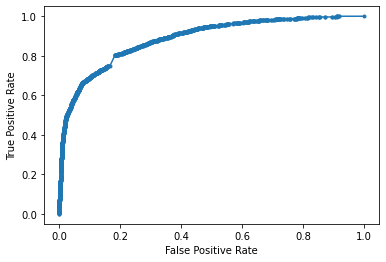

In [22]:
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

<h1>Apenas faces neutras</h1>

In [78]:
combinacoes = []
for x in range((qtdeHomens + qtdeMulheres)*qtdePoses*qtdeSessoes):
    if mesmaPessoa(x, x-qtdePoses):
        continue
    if x % qtdePoses == 0:
        combinacoes.append(x)
len(combinacoes)

136

In [79]:
shuffle(combinacoes)

In [80]:
porcTrain = 0.5
porcVal = 0.2
porcTest = 0.3

In [81]:
pTrain = combinacoes[:int(porcTrain*len(combinacoes))]
pVal = combinacoes[int(porcTrain*len(combinacoes)):int(porcTrain*len(combinacoes) + porcVal*len(combinacoes))]
pTest = combinacoes[int(porcTrain*len(combinacoes) + porcVal*len(combinacoes)):]

train = []
for i in range(len(pTrain)):
    train.append((pTrain[i],pTrain[i] + qtdePoses))

val = []
for i in range(len(pVal)):
    val.append((pVal[i],pVal[i] + qtdePoses))
            
test = []
for i in range(len(pTest)):
    test.append((pTest[i],pTest[i] + qtdePoses))

with open('trainFN.pkl', 'wb') as fid:
    cPickle.dump(train, fid) 
with open('testFN.pkl', 'wb') as fid:
    cPickle.dump(test, fid) 
with open('valFN.pkl', 'wb') as fid:
    cPickle.dump(val, fid) 


In [24]:
with open('trainFN.pkl', 'rb') as fid:
    train = cPickle.load(fid)
with open('valFN.pkl', 'rb') as fid:
    val = cPickle.load(fid)
with open('testFN.pkl', 'rb') as fid:
    test = cPickle.load(fid)

In [86]:
for tup in train:
    if not mesmaPessoa(tup[0], tup[1]):
        print('Problema!')

In [25]:
dictTrain = defaultdict(list)
for tup in train:
    dictTrain[tup[0]] = True
    dictTrain[tup[1]] = True
    
dictVal = defaultdict(list)
for tup in val:
    dictVal[tup[0]] = True
    dictVal[tup[1]] = True

dictTest = defaultdict(list)
for tup in test:
    dictTest[tup[0]] = True
    dictTest[tup[1]] = True

In [26]:
file_path = "vgg_face_neutral.h5"

#checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

#reduce_on_plateau = ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.1, patience=20, verbose=1)

#es = EarlyStopping(monitor='val_acc',patience=20)

#callbacks_list = [checkpoint, reduce_on_plateau]

model = baseline_model()
model.load_weights(file_path)
#model.fit_generator(gen(train, dictTrain, filenames, batch_size=8), use_multiprocessing=False,
#                    validation_data=gen(val, dictVal, filenames, batch_size=8), epochs=20, verbose=1,
#                    workers=1, callbacks=callbacks_list, steps_per_epoch=64, validation_steps=32)

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Functional)   (None, None, None, 2 23561152    input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 1, 1, 4096)   0           vggface_resnet50[0][0]

In [106]:
yTest = [1] * 8 + [0] * 8
num_test = 400
yTest = yTest * num_test
#print('Iniciando predição')
#pred2 = model.predict_generator(gen(test, dictTest, filenames, batch_size=16), num_test, verbose=1)
#print('Predição realizada')
#with open('predFN.pkl', 'wb') as fid:
#    cPickle.dump(pred2, fid) 

Iniciando predição
400/400 [==============================] - 6429s 16s/step
Predição realizada


In [107]:
fpr, tpr, thres = roc_curve(yTest, pred2)

Text(0, 0.5, 'True Positive Rate')

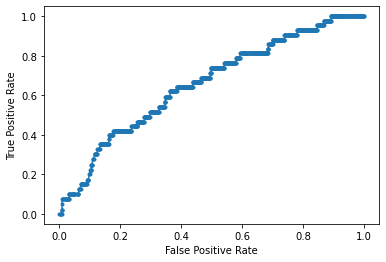

In [108]:
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#O treinamento apenas com faces neutras não apresentou bons resultados

In [100]:
#utilizando o modelo treinado com  todas as faces
file_path = "vgg_face.h5"
model.load_weights(file_path)

In [27]:
yTest = [1] * 8 + [0] * 8
num_test = 200
yTest = yTest * num_test
#print('Iniciando predição')
#pred2 = model.predict_generator(gen(test, dictTest, filenames, batch_size=16), num_test, verbose=1)
#print('Predição realizada')
#with open('predFN2.pkl', 'wb') as fid:
#    cPickle.dump(pred2, fid) 
with open('predFN2.pkl', 'rb') as fid:
    pred2 = cPickle.load(fid)

In [28]:
with open('actualFN2.pkl', 'wb') as fid:
    cPickle.dump(yTest, fid) 

In [29]:
fpr, tpr, thres = roc_curve(yTest, pred2)

Text(0, 0.5, 'True Positive Rate')

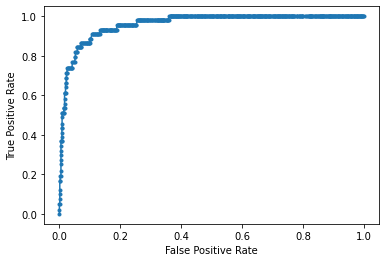

In [30]:
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#Utilizando o modelo treinado com todas as faces os resultados são melhores

<h1>Região ocular esquerda</h1>

In [111]:
combinacoes = []
for x in range((qtdeHomens + qtdeMulheres)*qtdePoses*qtdeSessoes):
    if mesmaPessoa(x, x-qtdePoses):
        continue
    if x % qtdePoses == 0:
        combinacoes.append(x)
len(combinacoes)

136

In [112]:
shuffle(combinacoes)

In [113]:
porcTrain = 0.5
porcVal = 0.2
porcTest = 0.3

In [115]:
pTrain = combinacoes[:int(porcTrain*len(combinacoes))]
pVal = combinacoes[int(porcTrain*len(combinacoes)):int(porcTrain*len(combinacoes) + porcVal*len(combinacoes))]
pTest = combinacoes[int(porcTrain*len(combinacoes) + porcVal*len(combinacoes)):]

train = []
for i in range(len(pTrain)):
    for ses in range(qtdeSessoes):
        for pos in {1, 2, 3, 4, 5, 6, 10, 11, 12}:
            train.append((pTrain[i],pTrain[i] + qtdePoses*ses + pos))

val = []
for i in range(len(pVal)):
    for ses in range(qtdeSessoes):
        for pos in {1, 2, 3, 4, 5, 6, 10, 11, 12}:
            val.append((pVal[i],pVal[i] + qtdePoses*ses + pos))
            
test = []
for i in range(len(pTest)):
    for ses in range(qtdeSessoes):
        for pos in {1, 2, 3, 4, 5, 6, 10, 11, 12}:
            test.append((pTest[i],pTest[i] + qtdePoses*ses + pos))

with open('trainEye.pkl', 'wb') as fid:
    cPickle.dump(train, fid) 
with open('testEye.pkl', 'wb') as fid:
    cPickle.dump(test, fid) 
with open('valEye.pkl', 'wb') as fid:
    cPickle.dump(val, fid) 


In [39]:
with open('trainEye.pkl', 'rb') as fid:
    train = cPickle.load(fid)
with open('valEye.pkl', 'rb') as fid:
    val = cPickle.load(fid)
with open('testEye.pkl', 'rb') as fid:
    test = cPickle.load(fid)

In [136]:
for tup in train:
    if not mesmaPessoa(tup[0], tup[1]):
        print('Problema!')

In [137]:
len(train)

1224

In [40]:
dictTrain = defaultdict(list)
for tup in train:
    dictTrain[tup[0]] = True
    dictTrain[tup[1]] = True
    
dictVal = defaultdict(list)
for tup in val:
    dictVal[tup[0]] = True
    dictVal[tup[1]] = True

dictTest = defaultdict(list)
for tup in test:
    dictTest[tup[0]] = True
    dictTest[tup[1]] = True

In [42]:
file_path = "vgg_face.h5" #testando com o modelo treinado com todas as faces

#checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

#reduce_on_plateau = ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.1, patience=20, verbose=1)

#es = EarlyStopping(monitor='val_acc',patience=20)

#callbacks_list = [checkpoint, reduce_on_plateau]

model = baseline_model()
model.load_weights(file_path)
#model.fit_generator(genEye(train, dictTrain, filenames, batch_size=8), use_multiprocessing=False,
                  #  validation_data=genEye(val, dictVal, filenames, batch_size=8), epochs=20, verbose=1,
                   # workers=1, callbacks=callbacks_list, steps_per_epoch=64, validation_steps=16)

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Functional)   (None, None, None, 2 23561152    input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 1, 1, 4096)   0           vggface_resnet50[0][0

In [43]:
yTest = [1] * 8 + [0] * 8
num_test = 64
yTest = yTest * num_test
print('Iniciando predição')
pred2 = model.predict_generator(genEye(test, dictTest, filenames, batch_size=16), num_test, verbose=1)
print('Predição realizada')
with open('predEye.pkl', 'wb') as fid:
    cPickle.dump(pred2, fid) 

Iniciando predição
Instructions for updating:
Please use Model.predict, which supports generators.
64/64 [==============================] - 928s 14s/step
Predição realizada


In [44]:
fpr, tpr, thres = roc_curve(yTest, pred2)

Text(0, 0.5, 'True Positive Rate')

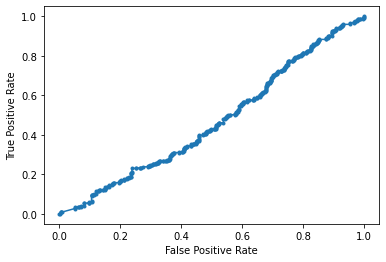

In [45]:
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')